# Implementing a GPT model from scratch to generate text


* Coding a GPT-like large language model (LLM)
that can be trained to generate human-like text
* Normalizing layer activations to stabilize neural
network training
* Adding shortcut connections in deep neural
networks
* Implementing transformer blocks to create GPT
models of various sizes
* Computing the number of parameters and
storage requirements of GPT models
* 12 transformers block in GPT2 124M
* To put the scale of our project into perspective, consider the training of the 7 billion parameter Llama 2 model, a relatively popular openly available LLM. This model required 184,320 GPU hours on expensive A100 GPUs, processing 2 trillion tokens. At the time of writing, running an 8 × A100 cloud server on AWS costs around $30 per hour. A rough estimate puts the total training cost of such an LLM at around $690,000 (calculated as 184,320 hours divided by 8, then multiplied by $30).

... it would take 355 years to train GPT-3 (175 billion) on a single V100 datacenter GPU
and 665 years on a consumer RTX 8000 GPU.


In [6]:
GPT_CONFIG_124M = {
"vocab_size": 50257, # Vocabulary size
"context_length": 1024, # Context length
"emb_dim": 768, # Embedding dimension
"n_heads": 12, # Number of attention heads
"n_layers": 12, # Number of layers
"drop_rate": 0.1, # Dropout rate
"qkv_bias": False # Query-Key-Value bias
}

In [7]:
import torch
import torch.nn as nn

In [8]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )
        
        self.final_norm = DummyLayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
        torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
    
    def forward(self, x):
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
    def forward(self, x):
        return x

In [9]:
import tiktoken
tokenizer = tiktoken.get_encoding('gpt2')
batch = []
txt1 = 'Every effort moves you'
txt2 = 'Every day holds a'
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [10]:
# Initialize the model 124M
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


##### Normalizing activations with layer normalization

In [11]:
torch.manual_seed(123)
batch_sample = torch.rand(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_sample)
print(out)

tensor([[0.0000, 0.0000, 0.4091, 0.6587, 0.3914, 0.0000],
        [0.0000, 0.0000, 0.1902, 0.3182, 0.6486, 0.0000]],
       grad_fn=<ReluBackward0>)


In [12]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print('Mean: \n', mean)
print('Variance: \n', var)

Mean: 
 tensor([[0.2432],
        [0.1928]], grad_fn=<MeanBackward1>)
Variance: 
 tensor([[0.0799],
        [0.0670]], grad_fn=<VarBackward0>)


In [13]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print('Normalized layer outputs: \n', out_norm)
print('Mean:\n', mean)
print('Variance:\n', var)

Normalized layer outputs: 
 tensor([[-0.8603, -0.8603,  0.5869,  1.4698,  0.5242, -0.8603],
        [-0.7450, -0.7450, -0.0102,  0.4844,  1.7608, -0.7450]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[0.0000e+00],
        [9.9341e-09]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


In [14]:
torch.set_printoptions(sci_mode=False)
print('Mean:\n', mean)
print('Variance:\n', var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


In [15]:
# A layer normalization class 

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


In [16]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_sample)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)


Mean:
 tensor([[     0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.9998],
        [0.9999]], grad_fn=<VarBackward0>)


##### Implementing a feed forward network with GELU activations

In [17]:
# GELU activation function
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
        ))

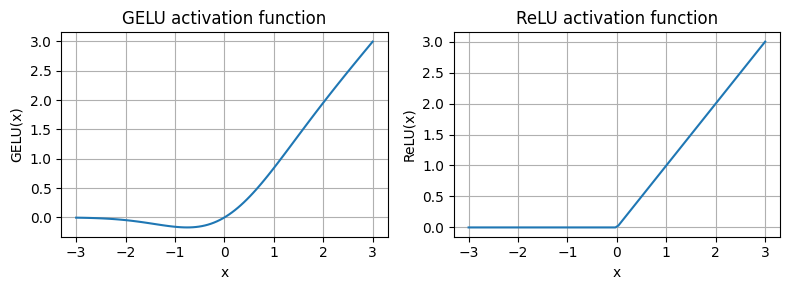

In [18]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
# Feedforward nn module
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], cfg['emb_dim'] * 4),
            GELU(),
            nn.Linear(cfg['emb_dim'] * 4, cfg['emb_dim'])
        )
    
    def forward(self, x):
        return self.layers(x)

In [20]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


##### Shortcut Connection (Skip or Residual)

In [21]:
# NN to illustrate shortcut connections
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]),
                          GELU())
        ])
    
    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x     
        

In [22]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)


In [23]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])
    loss_fn = nn.MSELoss()
    loss = loss_fn(output, target)
    
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name and param.grad is not None:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")


In [24]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


In [25]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472


In [26]:
'''Explanation of the Results

The results show how **shortcut connections** (or their absence) affect the gradients during training.

Results without shortcut (model without shortcut):
- The gradients for the layer weights are **smaller** with minimal variance across layers. 
- This suggests that the model updates weights more slowly and in a more stable manner, which is typical for standard neural networks without shortcut connections.

Results with shortcut (model with shortcut):
- The gradients are significantly **larger**, ranging from 0.2 to 1.3 for different layers.
- This is because **shortcut connections** allow for **easier information flow** between layers, enhancing the **trainability** of the model.
- Larger gradients help the network update weights faster, especially in deep networks.

Conclusion:
- **Without shortcut:** Smaller gradients, possibly slower learning.
- **With shortcut:** Larger gradients, leading to faster training and better information flow in deep networks.'''

'Explanation of the Results\n\nThe results show how **shortcut connections** (or their absence) affect the gradients during training.\n\nResults without shortcut (model without shortcut):\n- The gradients for the layer weights are **smaller** with minimal variance across layers. \n- This suggests that the model updates weights more slowly and in a more stable manner, which is typical for standard neural networks without shortcut connections.\n\nResults with shortcut (model with shortcut):\n- The gradients are significantly **larger**, ranging from 0.2 to 1.3 for different layers.\n- This is because **shortcut connections** allow for **easier information flow** between layers, enhancing the **trainability** of the model.\n- Larger gradients help the network update weights faster, especially in deep networks.\n\nConclusion:\n- **Without shortcut:** Smaller gradients, possibly slower learning.\n- **With shortcut:** Larger gradients, leading to faster training and better information flow i

##### Connecting attention and linear layers in a transformer block

In [27]:
class MultiHeadAttention(nn.Module):
    """
    This class implements multi-head self-attention efficiently. 
    Instead of processing each attention head separately, it uses a single large weight matrix 
    and splits the outputs into multiple heads. This allows for parallel computation, 
    improving speed and reducing memory usage.

    Key features:
    - Uses a single set of weights for query, key, and value projections.
    - Splits the projected values into multiple attention heads.
    - Applies causal masking to prevent information leakage from future tokens.
    - Computes attention in parallel across all heads.
    - Uses an output projection layer to merge information from all heads.

    This implementation is more efficient than stacking multiple single-head attention layers.
    """
    
    def __init__(self, d_in, d_out, 
                 context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            'd_out must be divisible by num_heads'
        
        self.d_out = d_out
        self.num_heads = num_heads
        self.d_head = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            'mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
        
    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        keys = keys.view(b, num_tokens, self.num_heads, self.d_head)
        values = values.view(b, num_tokens, self.num_heads, self.d_head)
        queries = queries.view(b, num_tokens, self.num_heads, self.d_head)


        
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)
        
        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec 
        


In [28]:
# transformer block component of GPT

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg['emb_dim'],
            d_out=cfg['emb_dim'],
            context_length=cfg['context_length'],
            num_heads=cfg['n_heads'],
            dropout=cfg['drop_rate'],
            qkv_bias=cfg['qkv_bias'])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop = nn.Dropout(cfg['drop_rate'])
    
    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop(x)
        x = x + shortcut
        
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop(x)
        x = x + shortcut
        return x
    

In [29]:
torch.manual_seed(123)
x = torch.rand(2, 5, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 5, 768])
Output shape: torch.Size([2, 5, 768])


#### Coding the GPT model

In [30]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


In [31]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)
print(f'vocabulary size of the tokenizer: {50257}')

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)
vocabulary size of the tokenizer: 50257


In [32]:
# number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [33]:
# trainable parameters
total_params_gpt2 = (
total_params - sum(p.numel()
for p in model.out_head.parameters())
)
print(f"Number of trainable parameters "
f"considering weight tying: {total_params_gpt2:,}"
)

Number of trainable parameters considering weight tying: 124,412,160


In [34]:
# model size
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


#### Generating text

This code demonstrates a simple implementation of a generative loop for a lan-
guage model using PyTorch. It iterates for a specified number of new tokens to be
generated, crops the current context to fit the model’s maximum context size, com-
putes predictions, and then selects the next token based on the highest probability
prediction.

In [35]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    '''
    Generates text using a GPT model.

    Parameters:
    - model: The GPT model.
    - idx: The current token sequence (batch, n_tokens).
    - max_new_tokens: Number of new tokens to generate.
    - context_size: Maximum number of tokens used as context.

    Returns:
    - Updated idx with newly generated tokens.
    '''
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]  # Keep only the last context_size tokens
        with torch.no_grad():
            logits = model(idx_cond)  # Get model predictions

        logits = logits[:, -1, :]  # Focus on the last time step
        probas = torch.softmax(logits, dim=-1)  # Convert logits to probabilities
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # Select the most probable token
        idx = torch.cat((idx, idx_next), dim=1)  # Append the new token

    return idx


In [36]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [37]:
model.eval()
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"])
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [38]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text + "\n")
print('! The model is unable to produce coherent text is that we haven’t trained it yet.')

Hello, I am Featureiman Byeswickattribute argue

! The model is unable to produce coherent text is that we haven’t trained it yet.


## Summary

- **Layer normalization** stabilizes training by ensuring that each layer’s outputs have a consistent mean and variance.  
- **Shortcut connections** skip one or more layers, allowing outputs to be fed directly to deeper layers. This helps mitigate the **vanishing gradient problem**, especially in deep neural networks like LLMs.  
- **Transformer blocks** are the core of GPT models, combining **masked multi-head attention** with **fully connected feed-forward networks** that use the **GELU activation function**.  
- **GPT models** are LLMs composed of multiple **repeated transformer blocks**, containing **millions to billions of parameters**.  
- **GPT models come in different sizes**, such as **124M, 345M, 762M, and 1,542M parameters**, all of which can be implemented using the same `GPTModel` Python class.  
- **Text generation in GPT models** involves decoding output tensors into human-readable text by **predicting one token at a time** based on a given input context.  
- **Without training, a GPT model generates incoherent text**, highlighting the necessity of training for coherent text generation.  


## Pretraining on unlabeled data

##### Using GPT to generate text

In [39]:
GPT_CONFIG_124M = {
"vocab_size": 50257,
"context_length": 256,  # original: 1024
"emb_dim": 768,
"n_heads": 12,
"n_layers": 12,
"drop_rate": 0.1,
"qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out

In [40]:
import torch
import tiktoken

def text_to_token_ids(text, tokenizer):
    """
    Converts a text string into a tensor of token IDs using the specified tokenizer.

    Parameters:
    - text: The input string to tokenize.
    - tokenizer: The tokenizer used to encode the text.

    Returns:
    - A PyTorch tensor containing the token IDs with an added batch dimension.
    """
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # Add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    """
    Converts a tensor of token IDs back into a human-readable text string.

    Parameters:
    - token_ids: A tensor containing token IDs.
    - tokenizer: The tokenizer used to decode the token IDs.

    Returns:
    - A decoded text string.
    """
    flat = token_ids.squeeze(0)  # Remove batch dimension
    return tokenizer.decode(flat.tolist())

# Define the initial text input
start_context = "Every effort moves you"

# Load the GPT-2 tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

# Generate new token IDs using the GPT model
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

# Convert generated token IDs back to text and print
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


##### Calculating the text generation loss

In [41]:
inputs = torch.tensor([[16833, 3626, 6100],  # ["every effort moves",
                          [40, 1107, 588]])  # "I really like"]

In [42]:
targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
                       [1107, 588, 11311]]) # " really like chocolate"]

In [43]:
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [44]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [45]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [46]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([    0.0001,     0.0000,     0.0000])
Text 2: tensor([    0.0000,     0.0001,     0.0000])


In [47]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [48]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


In [49]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [50]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [51]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


##### Calculating the training and validation set losses

In [52]:
file_path = 'the-verdict.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    text_data = file.read()

In [53]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print('Characters:', total_characters)
print('Tokens:', total_tokens)

Characters: 20479
Tokens: 5145


In [54]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [55]:
import torch
import tiktoken
from torch.utils.data import DataLoader

class GPTDatasetV1:
    def __init__(self, txt, tokenizer, max_length, stride):
        self.tokenizer = tokenizer
        self.tokens = tokenizer.encode(txt)
        self.max_length = max_length
        self.stride = stride
        self.samples = self._create_samples()

    def _create_samples(self):
        samples = []
        for i in range(0, len(self.tokens) - self.max_length, self.stride):
            input_tokens = self.tokens[i:i + self.max_length]
            target_tokens = self.tokens[i + 1:i + self.max_length + 1]
            samples.append((input_tokens, target_tokens))  # Возвращаем кортеж (входные данные, цель)
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        input_tokens, target_tokens = self.samples[idx]
        return torch.tensor(input_tokens, dtype=torch.long), torch.tensor(target_tokens, dtype=torch.long)

def collate_fn(batch):
    inputs, targets = zip(*batch)  # Разбиваем batch на входные данные и цели
    inputs = torch.stack(inputs)  # Превращаем в батч тензоров
    targets = torch.stack(targets)
    return inputs, targets

def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")  # Инициализация токенизатора
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)  # Создание датасета
    
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        collate_fn=collate_fn  # Добавляем collate_fn для преобразования в тензоры
    )
    
    return dataloader

In [56]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=False,
    num_workers=0
)

In [57]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)
    
print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [58]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
    logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

In [59]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.

    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break

    return total_loss / num_batches


In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583690219456
Validation loss: 10.98110580444336


##### Training an LLM

Training Process in PyTorch

1. **Loop over epochs** – Full pass through the dataset.
2. **Loop over batches** – Split data into mini-batches.
3. **Zero gradients** – Reset gradients to prevent accumulation:
   ```python
   optimizer.zero_grad()
   ```
4. **Compute loss** – Forward pass and loss calculation:
   ```python
   outputs = model(input_batch)
   loss = loss_function(outputs, target_batch)
   ```
5. **Backpropagation** – Compute gradients:
   ```python
   loss.backward()
   ```
6. **Update weights** – Adjust model parameters:
   ```python
   optimizer.step()
   ```
7. **Print losses** – Monitor training and validation loss.
8. **Generate text (optional)** – Inspect model output:
   ```python
   sample_text = generate_text(model, tokenizer, prompt="AI is")
   print(sample_text)
   ```

In [61]:
# The main function for pretraining LLMs

def train_model_simple(model, train_loader, val_loader,
                        optimizer, device, num_epochs,
                        eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    
    for epoch in range(num_epochs):  # Main training loop
        model.train()  
        
        for input_batch, target_batch in train_loader:  # Iterate over batches
            optimizer.zero_grad()  # Reset gradients
            loss = calc_loss_batch(input_batch, target_batch, model, device)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model weights

            tokens_seen += input_batch.numel()  # Track number of processed tokens
            global_step += 1  

            if global_step % eval_freq == 0:  # Evaluate model at specified intervals
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

                generate_and_print_sample(model, tokenizer, device, start_context)  # Generate sample text

    return train_losses, val_losses, track_tokens_seen


In [62]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()  # Set the model to evaluation mode (disables dropout, batch norm updates)
    
    with torch.no_grad():  # Disable gradient computation to save memory and speed up evaluation
        train_loss = calc_loss_loader(train_loader, model, device,      num_batches=eval_iter)  # Compute train loss
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)  # Compute validation loss

    model.train()  # Set the model back to training mode
    return train_loss, val_loss  # Return computed losses

In [63]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()  # Set model to evaluation mode (disables dropout, batch norm updates)

    context_size = model.pos_emb.weight.shape[0]  # Get the context size from positional embeddings
    encoded = text_to_token_ids(start_context, tokenizer).to(device)  # Encode input text and move to device

    with torch.no_grad():  # Disable gradient tracking for efficiency
        token_ids = generate_text_simple(
            model=model, idx=encoded, 
            max_new_tokens=50, context_size=context_size  # Generate up to 50 new tokens
        )

    decoded_text = token_ids_to_text(token_ids, tokenizer)  # Convert token IDs back to text
    print(decoded_text.replace("\n", " "))  # Print output with newlines replaced for readability

    model.train()  # Switch model back to training mode

In [64]:
torch.manual_seed(123)  # Set random seed for reproducibility
model = GPTModel(GPT_CONFIG_124M)  # Initialize the model with the given configuration
model.to(device)  # Move the model to the appropriate device (CPU or GPU)

# Initialize the optimizer (AdamW with learning rate and weight decay)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004,  # Learning rate
    weight_decay=0.1  # Weight decay (L2 regularization)
)

num_epochs = 10  # Number of epochs for training

# Train the model using the simple training loop
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,  # Model, data loaders, optimizer, device
    num_epochs=num_epochs,  # Number of epochs
    eval_freq=5,  # Frequency of evaluation during training (every 5 steps)
    eval_iter=5,  # Number of iterations for evaluation
    start_context="Every effort moves you",  # Initial text for text generation during evaluation
    tokenizer=tokenizer  # Tokenizer used for processing text
)


Ep 1 (Step 000000): Train loss 9.783, Val loss 9.927
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,, the,,,,,,,,,,,,,,,,,,,,
Ep 1 (Step 000005): Train loss 7.985, Val loss 8.335
Every effort moves you, the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Ep 2 (Step 000010): Train loss 6.753, Val loss 7.048
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Step 000015): Train loss 6.114, Val loss 6.573
Every effort moves you, the to the to the.                                           
Ep 3 (Step 000020): Train loss 5.525, Val loss 6.490
Every effort moves you, and, and the of the of the of the of the of the of the of the of the of the of the of the of the the of the the of the of the of the of the of the of the of the of the of
Ep 3 (Step 000025): Train loss 5.324, Val loss 6.387
Every effort moves you his " to 

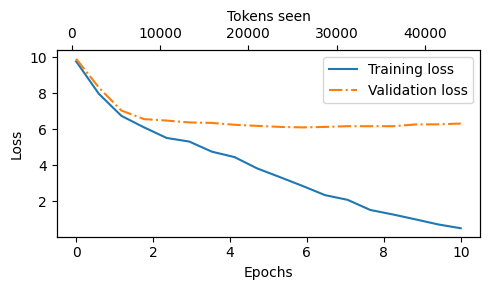

In [65]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Function to plot training and validation losses
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    # Create a figure and axis for plotting
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot the training and validation losses against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    
    # Set the x and y axis labels
    ax1.set_xlabel("Epochs")  # X-axis label for epochs
    ax1.set_ylabel("Loss")  # Y-axis label for loss

    # Display a legend for the plot
    ax1.legend(loc="upper right")
    
    # Ensure that the x-axis ticks are integer values
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Create a second x-axis (top) for tokens seen
    ax2 = ax1.twiny()

    # Plot an invisible line to link the top x-axis (tokens_seen) to the training losses
    ax2.plot(tokens_seen, train_losses, alpha=0)  # alpha=0 makes the line invisible

    # Set the label for the second x-axis (tokens seen)
    ax2.set_xlabel("Tokens seen")

    # Automatically adjust the layout to avoid overlapping labels and elements
    fig.tight_layout()

    # Show the plot
    plt.show()

# Create a tensor for epochs ranging from 0 to num_epochs with the same length as train_losses
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))

# Call the plot_losses function to plot the training and validation losses
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)


The resulting training and validation loss plot is shown in figure 5.12. As we can see, both the training and validation losses start to improve for the first epoch. However, the losses start to diverge past the second epoch. This divergence and the fact that the validation loss is much larger than the training loss indicate that the model is overfitting to the training data. We can confirm that the model memorizes the training data verbatim by searching for the generated text snippets, such as quite insensible to the irony in the “The Verdict” text file.

##### Decoding strategies to control randomness

In [66]:
model.to("cpu")  # Move the model to CPU
model.eval()  # Set the model to evaluation mode

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out

In [67]:
tokenizer = tiktoken.get_encoding("gpt2")  # Initialize the tokenizer
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




Temperature scaling 

In [69]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

In [ ]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
    )

In [71]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [74]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [75]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item()
    for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")
print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


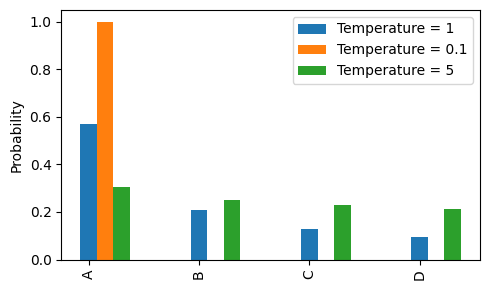

In [77]:
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T)
                 for T in temperatures]

x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))

for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
                   bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

Top-k sampling

In [80]:
top_k = 3

# Ensure next_token_logits is a tensor
if isinstance(next_token_logits, list):
    next_token_logits = torch.tensor(next_token_logits)

top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([2.0000, 1.0000, 0.5000])
Top positions: tensor([0, 1, 2])


In [81]:
# Create a mask where values lower than the smallest top-k logit are set to -inf
new_logits = torch.where(
    next_token_logits < top_logits[-1],  # Condition: if value < smallest top-k logit
    torch.full_like(next_token_logits, float('-inf')),  # Assign -inf
    next_token_logits  # Otherwise, keep original value
)

print("Modified logits:", new_logits)

Modified logits: tensor([2.0000, 1.0000, 0.5000,   -inf])


In [82]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.6285, 0.2312, 0.1402, 0.0000])


Modifying the text generation function

In [83]:
def generate(model, idx, max_new_tokens, context_size,
             temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]  # Limit the context to the last tokens
        
        with torch.no_grad():
            logits = model(idx_cond)  # Get model predictions
            logits = logits[:, -1, :]  # Focus on the last timestep logits
        
        # Apply top-k filtering
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, 
                                 torch.full_like(logits, float('-inf')), 
                                 logits)
        
        # Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)  # Sample from probabilities
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # Greedy selection
        
        # Stop generation if end-of-sequence token is reached
        if eos_id is not None and (idx_next == eos_id).all():
            break
        
        idx = torch.cat((idx, idx_next), dim=1)  # Append the new token to the sequence
    
    return idx


In [84]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to my surprise, a little it was the
"Ah enough
